# 重要说明

本代码尝试进行重构，发现了如下问题，最终考虑回滚到之前的代码状态：
* 环境类中的env.observation_space类和env.action_space定义问题，包括函数嵌套问题、迭代器问题等
* 对解决函数的agent来说，其无法实现最大价值动作的输出，原因是Q表定义、环境、动作的表示方式所致，以及，编程能力
* 之前进行构造的智能体存在的缺陷，目前是难以快速弥补的，而主要目的是为了做算法研究和发文章，对于编程能力，目前不在主要精力

# 环境

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
WORLD_HEIGHT = 4
WORLD_WIDTH = 12
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]
START = [3, 0]
GOAL = [3, 11]

class EnvObj():
  def __init__(self):
    pass

  def step(self, state, action):
    i, j = state
    if action == ACTION_UP:
        next_state = [max(i - 1, 0), j]
    elif action == ACTION_LEFT:
        next_state = [i, max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_DOWN:
        next_state = [min(i + 1, WORLD_HEIGHT - 1), j]
    else:
        assert False
    reward = -1
    if (action == ACTION_DOWN and i == 2 and 1 <= j <= 10) or (
        action == ACTION_RIGHT and state == START):
        reward = -100
        next_state = START
    return next_state, reward

  def choose_action(self, state, q_value, epsilon):
    if np.random.random() < epsilon:
      return np.random.choice(ACTIONS)
    else:
      values_ = q_value[state[0], state[1], :]
      return np.random.choice([action_ for action_, value_ in enumerate(values_)\
                               if value_ == np.max(values_)])


# 算法

In [21]:
# EPSILON = 0.1
# GAMMA = 1
# ALPHA = 0.5
class Learning():
  def __init__(self):
    self.env = EnvObj()

  def sarsa(self, q_value, expected, step_size, gamma):
    state = START
    EPSILON = 0.1
    action = self.env.choose_action(state, q_value, epsilon = EPSILON)
    rewards = 0.0
    while state != GOAL:
      next_state, reward = self.env.step(state, action)
      next_action = self.env.choose_action(next_state, 
                                           q_value, epsilon = EPSILON)
      rewards += reward
      if not expected:
          target = q_value[next_state[0], next_state[1], next_action]
      else:
          target = 0.0
          q_next = q_value[next_state[0], next_state[1], :]
          best_actions = np.argwhere(q_next == np.max(q_next))
          for action_ in ACTIONS:
              if action_ in best_actions:
                  target += ((1.0 - EPSILON) / len(best_actions) \
                             + EPSILON / len(ACTIONS)) \
                             * q_value[next_state[0], next_state[1], action_]
              else:
                  target += EPSILON / len(ACTIONS) \
                            * q_value[next_state[0], next_state[1], action_]
      target *= gamma
      q_value[state[0], state[1], action] += step_size \
                      * (reward + target - q_value[state[0], state[1], action])
      state = next_state
      action = next_action
    return rewards

  def q_learning(self, q_value, gamma, step_size):
      state = START
      rewards = 0.0
      while state != GOAL:
          action = self.env.choose_action(state, q_value, epsilon = 0.1)
          next_state, reward = self.env.step(state, action)
          rewards += reward
          # Q-Learning update
          q_value[state[0], state[1], action] += step_size * (
                  reward + gamma * 
                  np.max(q_value[next_state[0], next_state[1], :])
                   - q_value[state[0], state[1], action])
          state = next_state
      return rewards

  def print_optimal_policy(self, q_value):
      optimal_policy = []
      for i in range(0, WORLD_HEIGHT):
          optimal_policy.append([])
          for j in range(0, WORLD_WIDTH):
              if [i, j] == GOAL:
                  optimal_policy[-1].append('G')
                  continue
              bestAction = np.argmax(q_value[i, j, :])
              if bestAction == ACTION_UP:
                  optimal_policy[-1].append('U')
              elif bestAction == ACTION_DOWN:
                  optimal_policy[-1].append('D')
              elif bestAction == ACTION_LEFT:
                  optimal_policy[-1].append('L')
              elif bestAction == ACTION_RIGHT:
                  optimal_policy[-1].append('R')
      for row in optimal_policy:
          print(row)

# 效果

In [22]:
from tqdm import tqdm
runs = 20
episodes = 100
rewards_sarsa = np.zeros(episodes)
rewards_q_learning = np.zeros(episodes)
rewards_sarsa_exp = np.zeros(episodes)
def figure_6_4():
  global rewards_sarsa, rewards_q_learning, rewards_sarsa_exp
  obj_learning = Learning()
  for r in tqdm(range(runs)):
    q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    q_q_learning = np.copy(q_sarsa)
    q_sarsa_exp = np.copy(q_sarsa)
    for i in range(episodes):
      reward = obj_learning.sarsa(q_sarsa, expected = False,\
                                  gamma = 1, step_size= 1)
      rewards_sarsa[i] += reward

      reward = obj_learning.sarsa(q_sarsa_exp, expected = True,\
                                  gamma = 1, step_size = 1)
      rewards_sarsa_exp[i] += reward

      reward = obj_learning.q_learning(q_q_learning, gamma = 0.3,\
                                       step_size = 0.8)
      rewards_q_learning[i] += reward

  rewards_sarsa /= runs
  rewards_q_learning /= runs
  rewards_sarsa_exp /= runs
  print('')
  obj_learning.print_optimal_policy(q_sarsa)
  print('')
  obj_learning.print_optimal_policy(q_sarsa_exp)
  print('')
  obj_learning.print_optimal_policy(q_q_learning)
figure_6_4()

100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


['R', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'R', 'D']
['U', 'U', 'L', 'U', 'U', 'L', 'U', 'U', 'U', 'U', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']

['R', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']

['R', 'R', 'R', 'R', 'R', 'U', 'R', 'R', 'R', 'U', 'R', 'R']
['R', 'U', 'R', 'R', 'D', 'R', 'D', 'R', 'R', 'D', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']


## 效果1

(-200.0, 0.0)

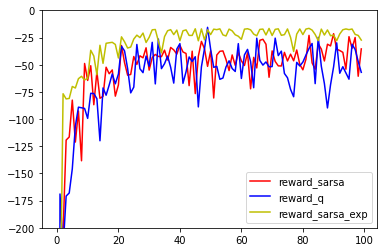

In [23]:
plt.plot(rewards_sarsa, c='r')
plt.plot(rewards_q_learning, c='b')
plt.plot(rewards_sarsa_exp,c='y')
plt.legend(['reward_sarsa', 'reward_q', 'reward_sarsa_exp'])
plt.ylim(-200, 0)

## 效果2

In [24]:
def regression(array):
  regress_value = []
  for i,value in enumerate(array):
    if (i+1) % 10 == 0:
      regress_value.append(array[i-10:i].mean())
  return regress_value

In [25]:
rewards_sarsa1 = regression(np.array(rewards_sarsa))
rewards_q_learning1 = regression(np.array(rewards_q_learning))
rewards_sarsa_exp1 = regression(np.array(rewards_sarsa_exp))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


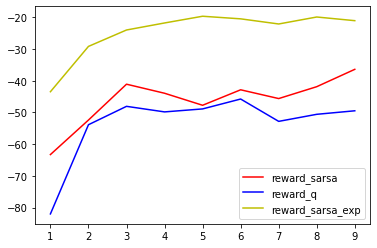

In [26]:
plt.plot(rewards_sarsa1, c='r')
plt.plot(rewards_q_learning1, c='b')
plt.plot(rewards_sarsa_exp1,c='y')
plt.legend(['reward_sarsa', 'reward_q', 'reward_sarsa_exp'])

# 工具

结束